# <center>  SI 630: Homework 2: Word2Vec
<center>  Codalab Usename: Wkailin


In [1]:
# %pip install torch torchvision
# %pip install gensim
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from tqdm.auto import tqdm, trange
from collections import Counter
import random
from torch import optim

from torch.utils.tensorboard import SummaryWriter

# Helpful for computing cosine similarity--Note that this is NOT a similarity!
from scipy.spatial.distance import cosine

# Handy command-line argument parsing
import argparse

# Sort of smart tokenization
from nltk.tokenize import RegexpTokenizer

# We'll use this to save our models
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")
#
# IMPORTANT NOTE: Always set your random seeds when dealing with stochastic
# algorithms as it lets your bugs be reproducible and (more importantly) it lets
# your results be reproducible by others.
#
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

### Task 1: Word2vec

#### Create a class to hold the data

Before we get to training word2vec, we'll need to process the corpus into some representation. The `Corpus` class will handle much of the functionality for corpus reading and keeping track of which word types belong to which ids. The `Corpus` class will also handle the crucial functionality of generating negative samples for training (i.e., randomly-sampled words that were not in the target word's context).

Some parts of this class can be completed after you've gotten word2vec up and running, so see the notes below and the details in the homework PDF.

In [2]:
class Corpus:
    def __init__(self):

        self.tokenizer = RegexpTokenizer(r'\w+')
        
        # These state variables become populated with function calls
        #
        # 1. load_data()
        # 2. generate_negative_sampling_table()
        # See those functions for how the various values get filled in

        self.word_to_index = {} # word to unique-id
        self.index_to_word = {} # unique-id to word

        # How many times each word occurs in our data after filtering
        self.word_counts = Counter()

        # A utility data structure that lets us quickly sample "negative"
        # instances in a context. This table contains unique-ids
        self.negative_sampling_table = []
        
        # The dataset we'll use for training, as a sequence of unqiue word
        # ids. This is the sequence across all documents after tokens have been
        # randomly subsampled by the word2vec preprocessing step
        self.full_token_sequence_as_ids = None
        
    def tokenize(self, text):
        '''
        Tokenize the document and returns a list of the tokens
        '''
        return self.tokenizer.tokenize(text)        

## Modify function load data in the Corpus class to read in the text data and fill in 
## the id to word, word to id, and full token sequence as ids fields
    def load_data(self, file_name, min_token_freq):
        '''
        Reads the data from the specified file as long long sequence of text
        (ignoring line breaks) and populates the data structures of this
        word2vec object.
        '''

        # Step 1: Read in the file and create a long sequence of tokens for
        # all tokens in the file
        with open(file_name,'r') as f:
            text = f.readlines()
        # convert to lower case
        text = [sen.lower() for sen in text]
        all_tokens = self.tokenize(' '.join(text))
        print('Reading data and tokenizing')
        
        # Step 2: Count how many tokens we have of each type
        count_tokens = Counter(all_tokens)
        print('Counting token frequencies')

        # Step 3: Replace all tokens below the specified frequency with an <UNK>
        # token. 
        count_tokens_unk = {key:value for key,value in count_tokens.items() 
                            if value>=min_token_freq
                           }
        count_tokens_unk['<UNK>'] = sum(
            np.array(list(count_tokens.values()))
            [np.array(list(count_tokens.values()))<min_token_freq])
        # NOTE: You can do this step later if needed
        print("Performing minimum thresholding")
        
        # Step 4: update self.word_counts to be the number of times each word
        # occurs (including <UNK>)
        self.word_counts = count_tokens_unk # counter{tokens:count}
        # Step 5: Create the mappings from word to unique integer ID and the
        # reverse mapping.
        # counter{tokens: token_ids}
        self.word_to_index = dict(zip(list(self.word_counts.keys()),
                                      np.arange(len(self.word_counts))
                                     )
                                 )
        self.index_to_word = dict(zip(np.arange(len(self.word_counts)),
                                 list(self.word_counts.keys())
                                     )
                                 )
        # Step 6: Compute the probability of keeping any particular *token* of a
        # word in the training sequence, which we'll use to subsample. This subsampling
        # avoids having the training data be filled with many overly common words
        # as positive examples in the context
        n = sum(self.word_counts.values())
        word_prob = np.array(list(self.word_counts.values()))/n #0.001
        word_prob = (np.sqrt(word_prob/0.001)+1)*(0.001/word_prob)
        word_to_sample_prob = dict(zip(self.index_to_word.keys(),word_prob))
        # Step 7: process the list of tokens (after min-freq filtering) to fill
        # self.full_token_sequence_as_ids: list of lists; unique ids
        self.full_token_sequence_as_ids = [[]] * len(text)
        for i in range(len(text)):
            token_seq = []
            for word in self.tokenize(text[i]):
                if word not in self.word_to_index.keys():
                    word = '<UNK>'
                if word_to_sample_prob[self.word_to_index[word]] > np.random.uniform():
                    token_seq.append(self.word_to_index[word])
            self.full_token_sequence_as_ids[i] = token_seq
                
        # Helpful print statement to verify what you've loaded
        print('Loaded all data from %s; saw %d tokens (%d unique)' \
              % (file_name, len(self.full_token_sequence_as_ids),
                 len(self.word_to_index)))
        
    def generate_negative_sampling_table(self, exp_power=0.75, table_size=1e6):
        '''
        Generates a big list data structure that we can quickly randomly index into
        in order to select a negative training example (i.e., a word that was
        *not* present in the context). 
        '''       
        # Step 1: Figure out how many instances of each word need to go into the
        # negative sampling table. # HINT: np.power and np.fill might be useful here        
        print("Generating sampling table")
        # num_w_neg: np.array, representing how many instances of each word need to go into the
        # negative sampling table
        num_w_neg = np.power(list(self.word_counts.values()), exp_power)
        num_w_neg = np.round(np.cumsum(num_w_neg/sum(num_w_neg)*table_size))
        num_w_neg = np.insert(np.diff(num_w_neg), 0, num_w_neg[0]).astype(int)      
        # Step 2: Create the table to the correct size. You'll want this to be a
        # numpy array of type int
        # Step 3: Fill the table so that each word has a number of IDs
        # proportionate to its probability of being sampled. 
        # table: int np.array to sample from
        self.negative_sampling_table = np.repeat(np.array(list(self.word_to_index.values())) ,
                          num_w_neg)
        
        # Example: if we have 3 words "a" "b" and "c" with probabilites 0.5,
        # 0.33, 0.16 and a table size of 6 then our table would look like this
        # (before converting the words to IDs):
        #
        # [ "a", "a", "a", "b", "b", "c" ]
        #
        pass


    def generate_negative_samples(self, cur_context_word_id, num_samples):
        '''
        Randomly samples the specified number of negative samples from the lookup
        table and returns this list of IDs as a numpy array. As a performance
        improvement, avoid sampling a negative example that has the same ID as
        the current positive context word.
        '''
        # Create a list and sample from the negative_sampling_table to
        # grow the list to num_samples, avoiding adding a negative example that
        # has the same ID as the current context_word
        # excluding cur_context_word_id
        n_neg_tab = len(self.negative_sampling_table)# get ids for neg samples
        while True:
            neg_id = random.sample(range(n_neg_tab), num_samples)
            if not np.intersect1d(neg_id,cur_context_word_id):
                break # no intersection
        results = self.negative_sampling_table[neg_id]
        return results

## Create the corpus

Now that we have code to turn the text into training data, let's do so. We've provided several files for you to help:

* `wiki-bios.DEBUG.txt` -- use this to debug your corpus reader
* `wiki-bios.10k.txt` -- use this to debug/verify the whole word2vec works
* `wiki-bios.med.txt` -- use this when everything works to generate your vectors for later parts
* `wiki-bios.HUGE.txt.gz` -- _do not use this_ unless (1) everything works and (2) you really want to test/explore. This file is not needed at all to do your homework.

We recommend startin to debug with the first file, as it is small and fast to load (quicker to find bugs). When debugging, we recommend setting the `min_token_freq` argument to 2 so that you can verify that part of the code is working but you still have enough word types left to test the rest.

You'll use the remaining files later, where they're described.

In the next cell, create your `Corpus`, read in the data, and generate the negative sampling table.

In [3]:
corpus_de = Corpus()
corpus_de.load_data('wiki-bios.DEBUG.txt', 5)
corpus_de.generate_negative_sampling_table()

Reading data and tokenizing
Counting token frequencies
Performing minimum thresholding
Loaded all data from wiki-bios.DEBUG.txt; saw 100 tokens (712 unique)
Generating sampling table


In [4]:
corpus_med = Corpus()
corpus_med.load_data('wiki-bios.med.txt', 5)
corpus_med.generate_negative_sampling_table()

Reading data and tokenizing
Counting token frequencies
Performing minimum thresholding
Loaded all data from wiki-bios.med.txt; saw 100000 tokens (96721 unique)
Generating sampling table


In [5]:
corpus = corpus_med

## Generate the training data

Once we have the corpus ready, we need to generate our training dataset. Each instance in the dataset is a target word and positive and negative examples of contexts words. Given the target word as input, we'll want to predict (or not predict) these positive and negative context words as outputs using our network. Your task here is to create a python `list` of instances. 

Your final training data should be a list of tuples in the format ([target_word_id], [word_id_1, ...], [predicted_labels]), where each item in the list is a list:
1. The first item is a list consisting only of the target word's ID.
2. The second item is a list of word ids for both context words and negative samples 
3. The third item is a list of labels to predicted for each of the word ids in the second list (i.e., `1` for context words and `0` for negative samples). 

You will feed these tuples into the PyTorch `DatasetLoader` later that will do the converstion to `Tensor` objects. You will need to make sure that all of the lists in each tuple are `np.array` instances and are not plain python lists for this `Tensor` converstion to work.

In [9]:
window_size = 2
num_negative_samples_per_target = 2
training_data = []
# Loop through each token in the corpus and generate an instance for each, 
# adding it to training_data
for i, seq in enumerate(tqdm(corpus.full_token_sequence_as_ids)):
    l = len(seq)
    n = window_size*2*(1+num_negative_samples_per_target)
    if i%10000==9999:
        print(i+1)
    for j, target in enumerate(seq):
        ## avoid creating a training instance when the target word is <UNK>
        if corpus.index_to_word[target]=='<UNK>': continue
        target_id = [target] # a list of ints(target word ids)
        word_id = [] # a list of list(text & negative ids)
        label = [] # a list of list(1 for context words and 0 for negative samples).
        context = seq[max(0,j-2):j] + seq[(j+1):min(l,j+3)] # a list
        if len(context)==0: continue
        neg_case = list(corpus.generate_negative_samples(context, len(context)*num_negative_samples_per_target))
        word_id = word_id + context + neg_case # 1+2; update word_id
        label = label + [1]*len(context) + [0]*len(neg_case) # 1+2; update label         
        # n_sup: num of neg cases should be added
        # add neg cases to get n 
        n_sup = n - len(word_id)#n - len(context)*(num_negative_samples_per_target+1)
        neg_sup = list(corpus.generate_negative_samples(context, n_sup))
        word_id = word_id +  neg_sup
        label = label + [0]*n_sup      
        training_data.append(tuple([target_id, word_id, label]))
    

  0%|          | 0/100000 [00:00<?, ?it/s]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


## Create the network

We'll create a new neural network as a subclass of `nn.Module` like we did in Homework 1. However, _unlike_ the network you built in Homework 1, we do not need to used linear layers to implement word2vec. Instead, we will use PyTorch's `Emedding` class, which maps an index (e.g., a word id in this case) to an embedding. 

Roughly speaking, word2vec's network makes a prediction by computing the dot product of the target word's embedding and a context word's embedding and then passing this dot product through the sigmoid function ($\sigma$) to predict the probability that the context word was actually in the context. The homework write-up has lots of details on how this works. Your `forward()` function will have to implement this computation.

In [11]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(Word2Vec, self).__init__()
        # Save what state you want and create the embeddings for your
        # target and context words
        self.target_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        # Once created, let's fill the embeddings with non-zero random
        # numbers. We need to do this to get the training started. 
        #
        # NOTE: Why do this? Think about what happens if all the embeddings
        # are all zeros initially. What would the predictions look like for
        # word2vec with these embeddings and how would the updated work?
        self.init_emb(init_range=0.5/vocab_size)
        pass      
    def init_emb(self, init_range):
        torch.manual_seed(630)
        self.target_embeddings.weight.data.uniform_(-init_range, init_range)
        self.context_embeddings.weight.data.uniform_(-init_range, init_range)
        # Fill your two embeddings with random numbers uniformly sampled
        # between +/- init_range
        pass
        
    def forward(self, target_word_id, context_word_ids):
        ''' 
        Predicts whether each context word was actually in the context of the target word.
        The input is a tensor with a single target word's id and a tensor containing each
        of the context words' ids (this includes both positive and negative examples).
        '''
        tensor_target = self.target_embeddings(torch.LongTensor(target_word_id))# tensor:  12 * batch_size* embedding_size
        tensor_conte = self.context_embeddings(torch.LongTensor(context_word_ids))
        output = torch.sum(torch.mul(tensor_target, tensor_conte),2)
        output = torch.sigmoid(output)
        return output
        

## Train the network!

Now that you have data in the right format and a neural network designed, it's time to train the network and see if it's all working. The trainin code will look surprisingly similar at times to your pytorch code from Homework 1 since all networks share the same base training setup. However, we'll add a few new elements to get you familiar with more common training techniques. 

For all steps, be sure to use the hyperparameters values described in the write-up.

1. Initialize your optimizer and loss function 
2. Create your network
3. Load your dataset into PyTorch's `DataLoader` class, which will take care of batching and shuffling for us (yay!)
4. Create a new `SummaryWriter` to periodically write our running-sum of the loss to a tensorboard
5. Train your model 

Two new elements show up. First, we'll be using `DataLoader` which is going to sample data for us and put it in a batch (and also convert the data to `Tensor` objects. You can iterate over the batches and each iteration will return all the items eventually, one batch at a time (a full epoch's worth).

The second new part is using `tensorboard`. As you might have noticed in Homework 1, training neural models can take some time. [TensorBoard](https://www.tensorflow.org/tensorboard/) is a handy web-based view that you can check during training to see how the model is doing. We'll use it here and periodically log a running sum of the loss after a set number of steps. The Homework write up has a plot of what this looks like. We'll be doing something simple here with tensorboard but it will come in handy later as you train larger models (for longer) and may want to visually check if your model is converging. TensorBoard was initially written for another deep learning framework, TensorFlow, but proved so useful it was ported to work in PyTorch too and is [easy to integrate](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html).

To start training, we recommend training on the `wiki-bios.10k.txt` dataset. This data is small enough you can get through an epoch in a few minutes (or less) while still being large enough you can test whether the model is learning anything by examining common words. Below this cell we've added a few helper functions that you can use to debug and query your model. In particular, the `get_neighbors()` function is a great way to test: if your model has learned anything, the nearest neighbors for common words should seem reasonable (without having to jump through mental hoops). An easy word to test on the `10k` data is "january" which should return month-related words as being most similar.

**NOTE**: Since we're training biographies, the text itself will be skewed towards words likely to show up biographices--which isn't necessary like "regular" text. You may find that your model has few instances of words you think are common, or that the model learns poor or unusual neighbors for these. When querying the neighbors, it can help to think of which words you think are likely to show up in biographies on Wikipedia and use those as probes to see what the model has learned.

Once you're convinced the model is learning, switch to the `med` data and train your model as specified in the PDF. Once trained, save your model using the `save()` function at the end of the notebook. This function records your data in a common format for word2vec vectors and lets you load the vectors into other libraries that have more advanced functionality. In particular, you can use the [gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) code in other notebook included to explore the vectors and do simple vector analogies.

In [12]:
# TODO: Set your training stuff, hyperparameters, models, tensorboard writer etc. here
# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

# del model
def training_emb(training_data = training_data,
                 batch_size = 16, v = len(corpus.index_to_word), # voc_size
                 k = 50, #(embedding size)
                 lr = 0.00005, #(learning rate)
                 min_token_freq = 5,
                 epochs = 1,
                 max_step = 10000):
    model = Word2Vec(v, k)
    loss_function = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    writer = SummaryWriter()
    for epoch in range(epochs):
        loss_sum = 0
        dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
        # TODO: use your DataLoader to iterate over the data
        with tqdm(dataloader) as t:
            # control the max_step based on the size of batches; 1/1000
            # max_step = min(max_step, int(2*t.total/100))
            for step, data in enumerate(t):
                # TODO: Fill in all the training details here
                # NOTE: since you created the data as a tuple of three np.array instances,
                # these have now been converted to Tensor objects for us
                target_ids, context_ids, labels = data    
                # training
                # convert to tensors
                target_ids = torch.stack(target_ids)
                context_ids = torch.stack(context_ids)
                labels = torch.stack(labels).type(torch.FloatTensor)
                # train the model
                outputs = model(target_ids, context_ids)
                loss = loss_function(outputs, labels)# Compute the loss. 
                # zero out the gradients from the old instance
                optimizer.zero_grad()
                loss.backward()# Calculate the gradient and how to update
                optimizer.step()# Update the model
                loss_sum += loss.item()
                if step%100==99:
                    writer.add_scalar("Loss/train", loss_sum, step)
                    writer.flush()
                    loss_sum = 0
                    t.update()

                if step > max_step:
                    break
    writer.close()
    return model, t

In [900]:
######## try different batch size
all_batch_size = [2, 8, 32, 64, 128, 256, 512]
#est_time = []
for bs in all_batch_size[-1:]:
    model1,t = training_emb(batch_size = bs, max_step = 5000)
    time = re.split(r':',re.split(r'[<,]',str(t))[1])
    time = sum([int(ele_time)/60**t_unit for t_unit, ele_time in enumerate([0]*(3-len(time))+time)])
    est_time.append(round(time,3))
    #print(est_time)

  0%|          | 0/8920779 [00:00<?, ?it/s]

[114.633]


  0%|          | 0/2230195 [00:00<?, ?it/s]

[114.633, 30.233]


  0%|          | 0/557549 [00:00<?, ?it/s]

[114.633, 30.233, 19.117]


  0%|          | 0/278775 [00:00<?, ?it/s]

[114.633, 30.233, 19.117, 11.167]


  0%|          | 0/139388 [00:00<?, ?it/s]

[114.633, 30.233, 19.117, 11.167, 2.267]


  0%|          | 0/69694 [00:00<?, ?it/s]

[114.633, 30.233, 19.117, 11.167, 2.267, 1.033]


  0%|          | 0/34847 [00:00<?, ?it/s]

[114.633, 30.233, 19.117, 11.167, 2.267, 1.033, 31.55]


<AxesSubplot:title={'center':'Batch size V.S. Estimated training time(1 epoch)'}, xlabel='Batch size', ylabel='Estimated training time(h/1 epoch)'>

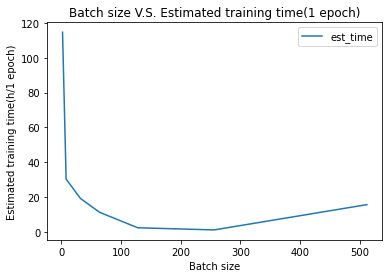

In [935]:
# make a plot
pd.DataFrame({'est_time':est_time, 'all_batch_size':all_batch_size}).plot(x = 'all_batch_size', y= 'est_time',
    xlabel = 'Batch size', ylabel = 'Estimated training time(h/1 epoch)',
                        title = 'Batch size V.S. Estimated training time(1 epoch)')

###  Problem 12.

For this question, I tried to run the training with different batch_size for a few times and get the plot above. 
As batch_size increases, it appears that estimated running time decreases first, and then began to increase. By checking the memory usage of my computer, I think one possible reason why that the training time increases dramatically when batch_size is 512 is that the memory usage is too high to handle. Given this factor, I think batch_size =256 or 128 is the best batch size that would maximize speed while ensuring sufficient memory usage.

### Problem 13.

In [14]:
final_model, final_model_timebar = training_emb(batch_size = 256, max_step = 99999)

  0%|          | 0/68368 [00:00<?, ?it/s]

I trained the model for 1 epoch, and here is a picture of the tensorboard plot from my training run.

<div>
<img src="tb_pic1.png" width="500"/>
</div>

## Verify things are working

Once you have an initial model trained, try using the following code to query the model for what are the nearest neighbor of a word. This code is intended to help you debug

In [15]:
def get_neighbors(model, word_to_index, target_word):
    """ 
    Finds the top 10 most similar words to a target word
    """
    outputs = []
    for word, index in tqdm(word_to_index.items(), total=len(word_to_index)):
        similarity = compute_cosine_similarity(model, word_to_index, target_word, word)
        result = {"word": word, "score": similarity}
        outputs.append(result)

    # Sort by highest scores
    neighbors = sorted(outputs, key=lambda o: o['score'], reverse=True)
    return neighbors[1:11]

def compute_cosine_similarity(model, word_to_index, word_one, word_two):
    '''
    Computes the cosine similarity between the two words
    '''
    try:
        word_one_index = word_to_index[word_one]
        word_two_index = word_to_index[word_two]
    except KeyError:
        return 0

    embedding_one = model.target_embeddings(torch.LongTensor([word_one_index]))
    embedding_two = model.target_embeddings(torch.LongTensor([word_two_index]))
    similarity = 1 - abs(float(cosine(embedding_one.detach().numpy(),
                                      embedding_two.detach().numpy())))
    return similarity

In [19]:
get_neighbors(final_model, corpus.word_to_index, "january")

  0%|          | 0/96721 [00:00<?, ?it/s]

[{'word': 'march', 'score': 0.9999642968177795},
 {'word': 'june', 'score': 0.9999534487724304},
 {'word': 'december', 'score': 0.9999221563339233},
 {'word': 'april', 'score': 0.9999035000801086},
 {'word': 'october', 'score': 0.9998877048492432},
 {'word': 'july', 'score': 0.9998447299003601},
 {'word': 'february', 'score': 0.9998365640640259},
 {'word': 'september', 'score': 0.9997960329055786},
 {'word': 'august', 'score': 0.9997805953025818},
 {'word': 'november', 'score': 0.9996955394744873}]

# Task 2: Save your model!

Once you have a fully trained model, save it using the code below. Note that we only save the `target_embeddings` from the model, but you could modify the code if you want to save the context vectors--or even try doing fancier things like saving the concatenation of the two or the average of the two!

In [20]:
def save_target(model, corpus, filename):
    '''
    Saves the model to the specified filename as a gensim KeyedVectors in the
    text format so you can load it separately.
    '''

    # Creates an empty KeyedVectors with our embedding size
    kv = KeyedVectors(vector_size=model.embedding_size)        
    vectors = []
    words = []
    # Get the list of words/vectors in a consistent order
    for index in trange(model.target_embeddings.num_embeddings):
        word = corpus.index_to_word[index]
        vectors.append(model.target_embeddings(torch.LongTensor([index])).detach().numpy()[0])
        words.append(word)
    # Fills the KV object with our data in the right order
    kv.add_vectors(words, vectors) 
    kv.save_word2vec_format(filename, binary=False)

### Task 2: Save Your Outputs

In [21]:
# save(final_model, corpus, filename)
save_target(final_model, corpus, 'final_model_target_emb.kv')

  0%|          | 0/96721 [00:00<?, ?it/s]

### Task 3: Qualitative Evaluation of Word Similarities

In [22]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

#### Problem 14.
Load the model (vectors) you saved in Task 2 by using the Jupyter notebook provided (or code that does something similar) that uses the Gensim package to read the vectors.
Gensim has a number of useful utilities for working with pretrained vectors.

In [23]:
word_vectors = KeyedVectors.load_word2vec_format('final_model_target_emb.kv', binary=False)

#### Problem 15. 
Pick 10 target words and compute the most similar for each using Gensim’s function. Qualitatively looking at the most similar words for each target word, do these predicted word
seem to be semantically similar to the target word? Describe what you see in 2-3 sentences. Hint:
For maximum effect, try picking words across a range of frequencies (common, occasional, rare
words).

In [34]:
#list(corpus.word_counts.keys())[:10]
def get_10_tw(corpus=corpus):
    corpus_lst = np.array(list(corpus.word_counts.keys()))
    corpus_freq = np.array(list(corpus.word_counts.values()))
    np.random.seed(666)
    com = np.random.choice(corpus_lst[corpus_freq>np.quantile(corpus_freq, 0.99)],3)
    mod = np.random.choice(corpus_lst[corpus_freq>np.quantile(corpus_freq, 0.95)],3)
    rate = np.random.choice(corpus_lst[corpus_freq<100],4)
    return np.concatenate([com,mod,rate],axis=0)

In [35]:
# pick 10 target words
target_word_10 = get_10_tw(corpus)
most_similar_word = []
for tw in target_word_10:
    sw = word_vectors.similar_by_word(tw)[0][0]
    most_similar_word.append(sw)
dict(zip(target_word_10,most_similar_word))

{'jersey': 'zealand',
 'schools': 'architecture',
 'great': 'include',
 'silver': 'olympic',
 'melbourne': 'sydney',
 'brother': 'mother',
 'por5': 'militar',
 'scalia': 'armaments',
 'nascent': 'abolition',
 'stp1': '1188'}

For the common words with relatively high frequency(Top 5%), these predicted word usually seem to be semantically similar to the target word. e.g. {'silver': 'olympic','game': 'match', 'who': 'what','Biography': 'Life'}

However, for the rare words with relatively lower frequency(usually names), the predicted word seem to be much less similar to the target word. This could be resulted from the lack of training samples, thus the embedding layer are less likely to get trained, which leads to the underfitting.

#### Problem 16. 
Given the analogy function, find five interesting word analogies with your word2vec
model. For example, when representing each word by word vectors, we can generate the following
equation, king - man + woman = queen. In other word, you can understand the equation as queen - woman = king - man, which mean the vectors similarity between queen and women is equal to
king and man. What kinds of other analogies can you find? (NOTE: Any analogies shown in the
class recording cannot be used for this problem.) What approaches worked and what approaches
didn’t? Write 2-3 seconds in a cell in the notebook.

In [59]:
def get_analogy(a, b, c):
    return word_vectors.most_similar(positive=[b, c], negative=[a])[0][0]
get_analogy('man', 'woman', 'king')

'music'

In [ ]:
# keep
get_analogy('child', 'women', 'work')
get_analogy('he', 'successful', 'she')
get_analogy('win', 'game', 'champion')
get_analogy('snow', 'boston', 'sunshine')
# not so reasonble
get_analogy('man', 'woman', 'king')
get_analogy('snow', 'michigan', 'california')
get_analogy('men', 'brother', 'her')

Based on the get_analogy() function and model, there are a few equations established, but not all equations seem to be semantically reasonable.

For example, 'successful' + 'she' = 'great' + 'he', 'win' + 'third'='game' +'champion' are quite semantically reasonable according to our prior knowledge. I believe the reason why is that these words in the equations are common words that appear frequently, thus the embeddings of these word are well-trained , which makes the predictions reasonable.

However, equations like 'michigan'+'california'-'snow'='University' seems much less interpretable. I think this is the case when the equation contains a component word that is highly correlated with a specific word, thus the prediction would be dominated by that word and ignoring other words.

Another counter case type that does not work well is the equation like 'brother' + 'her'- 'men'='henriksson'. Sometimes the predictions are rare words like people names or city names. I think this could be resulted from the lack of training on these rare words. I think one possible solution is to train the model for more epoches and get the embeddings of these words better tuned.

#  Task 4: Debiasing word2vec

# FINAL PART: DO THIS LAST AND READ CAREFULLY

Before you start this part, you need to have a fully working solution and completed the exploratory part of the assignment.

**Once you are ready, create a copy of your working notebook and call it `Debiased Word2Vec.ipynb`. Do not do this part in your working code for the assignment!!!**

## Seriously, save your code in a new file and then start reading the rest of these instructions there.

Ok, hopefully you're reading these in a new file... For this last part of the assignment, we're going to _change_ how word2vec learns at a fundamental level. 

As you might have noticed in your exploratory analysis, the word2vec model learns to weird and sometimes biased associations between words. In particular, your word2vec model has likely learned some unfortunate gender biases, e.g., that the vector for "nurse" is closer to "woman" than "man". The algorithm itself isn't to blame since it is learning these from a corpus (here, Wikipedia biographies) that contain biases already based on how people write. Wikipedia [is](http://markusstrohmaier.info/documents/2015_icwsm2015_wikipedia_gender.pdf) [well](http://dcs.gla.ac.uk/~mounia/Papers/wiki_gender_bias.pdf) [known](https://www.academia.edu/download/64856696/genderanalysisofWikipediabiostext_self_archived.pdf) for having gender biases in how it writes about men and women.


**Side note**: Some times this bias-learning behavior is useful: We can use word2vec to uncover these biases and analyze their trends, like this PNAS paper did for [looking at bias in news writing along multiple dimensions of identity](https://www.pnas.org/content/pnas/115/16/E3635.full.pdf)

In this last part of the homework, we'll ask how we might try to _prevent_ these biases by modifying the training. You won't need to solve this problem by any means, but the act of trying to reduce the biases will open up a whole new toolbox for how you (the experimenter/practioner) can change how and what models learn.

There are many potential ways to _debias_ word embeddings so that their representations are not skewed along one "latent dimension" like gender. In this homework, you'll be trying one of a few different ideas for how to do it. **You are not expected to solve gender bias! This part of the assignment is to have to start grappling with a hard challenge but there is no penalty for doing less-well!** 

One common technique to have models avoid learning bias is similar to another one you already&mdash;**regularization**. In Logistic Regression, we could use L2 regularization to have our model avoid learning $\beta$ weights that are overfit to specific or low-frequency features by adding a regularizer penalty where the larger the weight, the more penalty the model paid. Recall that this forces the model to only pick the most useful (generalizable) weights, since it has to pay a penalty for any non-zero weight. 

In word2vec, we can adapt the idea to think about whether our model's embeddings are closer or farther to different gender dimensions. For example, if we consider the embedding for "president", ideally, we'd want it to be equally similar to the embeddings for "man" and "woman". One idea then is to penalize the model based on how uneven the similarity is. We can do this by directly modifying the loss:
```
loss = loss_criteron(preds, actual_vals) + some_bias_measuring_function(model)
```
Here, the `some_bias_measuring_function` function takes in your model as input and returns how much bias you found. Continuing our example, we might implement it in pseudocode as
```
def some_bias_measuring_function(model):
    pres_woman_sim = cosine_similarity(model, "president", "woman")
    pres_man_sim = cosine_similarity(model, "president", "man")
    return abs(pres_woman_sim - pres_man_sim)
```
This simple example would penalize the model for learning a representation of "president" that is more simular to one of the two words. Of course, this example is overly simple. Why just "president"? Why just "man" and "woman"? Why not other words or other gender-related words or other gender identities?? 

Another idea might be to just make the vectors for "man" and "woman" be as similar as possible:
```
def some_bias_measuring_function(model):
    # cosine similarity is in [-1,1] but we mostly expect it in [0,1]
    man_woman_sim = cosine_similarity(model, "man", "woman")
    # penalize vectors that are not maximally similar, and avoid the edge case 
    # of negative cosine similarity
    return 1 - max(man_woman_sim, 0)
```

All of this works in practice because PyTorch is fantastic about tracking the gradient with respect to the loss. This ability lets us easily define a loss function so that our word2vec model (1) learns to predict the right context words while (2) avoids learning biases. If we compare this code to the numpy part of Homework 1, it's easy to see how powerful PyTorch can be as an experimenter for helping you control what and how your models learn!

Your task is to expand this general approach by coming up with an extension to word2vec that adds some new term to the `loss` value that penalizes bias in the gender dimension. There is no right way to do this and even some right-looking approaches may not work&mdash;or might word but simultaneously destroy the information in the word vectors (all-zero vectors are unbiased but also uninformative!). 

**Suggestion:** You may need to weight your bias term in the loss function (remember that $\lambda_1 x_1 + \lambda_2 x_2$ interpolation? This is sort of similar) so that your debiasing regularizer doesn't overly penalize your model.

Once you have generated your model, record word vector similarities for the pairs listed on canvas in `word-pair-similarity-predictions.csv` where your file writes a result like
```
word1,word2,sim
dog,puppy,0.91234123
woman,preseident,0.81234
```
You'll record the similarity for each pair of words in the file and upload it to CodaLab, which is kind of like Kaggle but lets use a custom scoring program. We'll evaluate your embeddings based on how unbiased they are and how much information they still capture after debiasing. **Your grade does not depend on how well you do in CodaLab, just that you tried something and submitted.** However, the CodaLab leaderboard will hopefully provide a fun and insightful way of comparing just how much bias we can remove from our embeddings.

The CodaLab link will be posted to Piazza

In [61]:
def cosine_similarity(model, ind1, ind2, corpus=corpus):
#     ind1 = corpus.word_to_index[w1]
#     ind2 = corpus.word_to_index[w2]
    return F.cosine_similarity(model.target_embeddings(ind1), 
                               model.target_embeddings(torch.LongTensor([ind2])),
                               dim=2
                              )
# model; corpus; target_id tensor;
def gender_bias_measuring_fun(model, corpus, target, gender1="woman", gender2="man"):
    g_id1 = corpus.word_to_index["woman"]
    g_id2 = corpus.word_to_index["man"]
    pres_woman_sim = cosine_similarity(model, target, g_id1)
    pres_man_sim = cosine_similarity(model, target, g_id2)
    bias_loss = torch.abs(torch.subtract(pres_woman_sim,pres_man_sim))
    return torch.mean(bias_loss)

In [62]:
def training_emb_debiase(training_data = training_data,
                 batch_size = 16,v = len(corpus.index_to_word), # voc_size
                 k = 50, #(embedding size)
                 lr = 0.00005, #(learning rate)
                 min_token_freq = 5,
                 epochs = 1,
                 max_step = 10000,
                lam = 0.1):
    model = Word2Vec(v, k)
    loss_function = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    writer = SummaryWriter()
    for epoch in range(epochs):
        loss_sum = 0
        dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
        # TODO: use your DataLoader to iterate over the data
        with tqdm(dataloader) as t:
            # control the max_step based on the size of batches; 1/1000
            # max_step = min(max_step, int(2*t.total/100))
            for step, data in enumerate(t):
                target_ids, context_ids, labels = data    
                # training convert to tensors
                target_ids = torch.stack(target_ids)
                context_ids = torch.stack(context_ids)
                labels = torch.stack(labels).type(torch.FloatTensor)
                # train the model
                outputs = model(target_ids, context_ids)
                ####### correct each target wrods bias on woman/man
                loss = loss_function(outputs, labels) + lam*gender_bias_measuring_fun(model, corpus, target_ids)
                # Compute the loss. 
                # zero out the gradients from the old instance
                optimizer.zero_grad()
                loss.backward()# Calculate the gradient and how to update
                optimizer.step()# Update the model
                loss_sum += loss.item()
                if step%100==99:
                    writer.add_scalar("Loss/train", loss_sum, step)
                    writer.flush()
                    loss_sum = 0
                    t.update()
                if step > max_step:
                    break

    # once you finish training, it's good practice to switch to eval.
    writer.close()
    return model, t

In [63]:
deb_model, deb_model_timebar = training_emb_debiase(batch_size = 256, max_step = 99000)

  0%|          | 0/68368 [00:00<?, ?it/s]

In [66]:
save_target(deb_model, corpus, 'deb_model_target_emb.kv')
deb_word_vectors = word_vectors = KeyedVectors.load_word2vec_format('deb_model_target_emb.kv', binary=False)
similar_data = pd.read_csv('./word_pair_similarity_predictions.csv')
pred_similar = []
# give corpus; model
for j in range(similar_data.shape[0]):
    ind1 = corpus.word_to_index[similar_data.iloc[j,0]]
    ind2 = corpus.word_to_index[similar_data.iloc[j,1]]
    pred_similar.append(deb_word_vectors.n_similarity(similar_data.iloc[j,0], similar_data.iloc[j,1]))
similar_data['sim'] =pred_similar
similar_data.head()
similar_data.to_csv('output_word_pair_similarity_predictions.csv')

  0%|          | 0/96721 [00:00<?, ?it/s]